# Survival Estimates that Vary with Time

Welcome to the third assignment of Course 2. In this assignment, we'll use Python to build some of the statistical models we learned this past week to analyze surivival estimates for a dataset of lymphoma patients. We'll also evaluate these models and interpret their outputs. Along the way, you will be learning about the following: 

- Censored Data
- Kaplan-Meier Estimates
- Subgroup Analysis

## Outline

- [1. Import Packages](#1)
- [2. Load the Dataset](#2)
- [3. Censored Data](#)
    - [Exercise 1](#Ex-1)
- [4. Survival Estimates](#4)
    - [Exercise 2](#Ex-2)
    - [Exercise 3](#Ex-3)
- [5. Subgroup Analysis](#5)
    - [5.1 Bonus: Log Rank Test](#5-1)

<a name='1'></a>
## 1. Import Packages

We'll first import all the packages that we need for this assignment. 

- `lifelines` is an open-source library for data analysis.
- `numpy` is the fundamental package for scientific computing in python.
- `pandas` is what we'll use to manipulate our data.
- `matplotlib` is a plotting library.

In [1]:
import lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util import load_data

from lifelines import KaplanMeierFitter as KM
from lifelines.statistics import logrank_test

<a name='2'></a>
## 2. Load the Dataset


Run the next cell to load the lymphoma data set. 

In [2]:
data = load_data()

As always, you first look over your data.

In [3]:
print("data shape: {}".format(data.shape))
data.head()

data shape: (80, 3)


,Stage_group,Time,Event
0,1,6,1
1,1,19,1
2,1,32,1
3,1,42,1
4,1,42,1


The column `Time` states how long the patient lived before they died or were censored.

The column `Event` says whether a death was observed or not. `Event` is 1 if the event is observed (i.e. the patient died) and 0 if data was censored.

Censorship here means that the observation has ended without any observed event.
For example, let a patient be in a hospital for 100 days at most. If a patient dies after only 44 days, their event will be recorded as `Time = 44` and `Event = 1`. If a patient walks out after 100 days and dies 3 days later (103 days total), this event is not observed in our process and the corresponding row has `Time = 100` and `Event = 0`. If a patient survives for 25 years after being admitted, their data for are still `Time = 100` and `Event = 0`.

<a name='3'></a>
## 3. Censored Data

We can plot a histogram of the survival times to see in general how long cases survived before censorship or events.

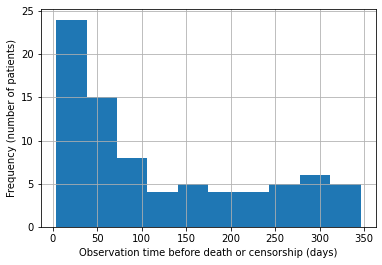

In [4]:
data.Time.hist();
plt.xlabel("Observation time before death or censorship (days)");
plt.ylabel("Frequency (number of patients)");
# Note that the semicolon at the end of the plotting line
# silences unnecessary textual output - try removing it
# to observe its effect

<a name='Ex-1'></a>
### Exercise 1

In the next cell, write a function to compute the fraction ($\in [0, 1]$) of observations which were censored. 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Summing up the <code>'Event'</code> column will give you the number of observations where censorship has NOT occurred.</li>
    
</ul>
</p>

In [5]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def frac_censored(df):
    """
    Return percent of observations which were censored.
    
    Args:
        df (dataframe): dataframe which contains column 'Event' which is 
                        1 if an event occurred (death)
                        0 if the event did not occur (censored)
    Returns:
        frac_censored (float): fraction of cases which were censored. 
    """
    result = 0.0
    
    ### START CODE HERE ###
    result=len(df[df.Event ==0]) / len(df)
    
    
    ### END CODE HERE ###
    
    return result

In [6]:
print(frac_censored(data))

0.325


#### Expected Output:
```CPP
0.325
```

Run the next cell to see the distributions of survival times for censored and uncensored examples.

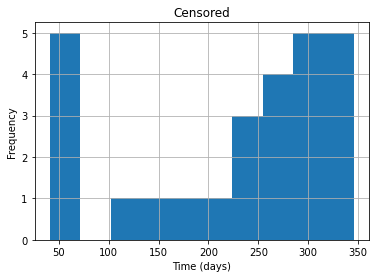

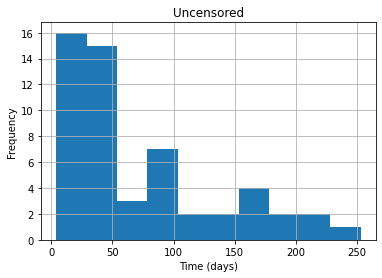

In [7]:
df_censored = data[data.Event == 0]
df_uncensored = data[data.Event == 1]

df_censored.Time.hist()
plt.title("Censored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

df_uncensored.Time.hist()
plt.title("Uncensored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

<a name='4'></a>
## 4. Survival Estimates

We'll now try to estimate the survival function:

$$
S(t) = P(T > t)
$$

To illustrate the strengths of Kaplan Meier, we'll start with a naive estimator of the above survival function. To estimate this quantity, we'll divide the number of people who we know lived past time $t$ by the number of people who were not censored before $t$.

Formally, let $i$ = 1, ..., $n$ be the cases, and let $t_i$ be the time when $i$ was censored or an event happened. Let $e_i= 1$ if an event was observed for $i$ and 0 otherwise. Then let $X_t = \{i : T_i > t\}$, and let $M_t = \{i : e_i = 1 \text{ or } T_i > t\}$. The estimator you will compute will be:

$$
\hat{S}(t) = \frac{|X_t|}{|M_t|}
$$



<a name='Ex-2'></a>
### Exercise 2
Write a function to compute this estimate for arbitrary $t$ in the cell below.

In [83]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def naive_estimator(t, df):
    """
    Return naive estimate for S(t), the probability
    of surviving past time t. Given by number
    of cases who survived past time t divided by the
    number of cases who weren't censored before time t.
    
    Args:
        t (int): query time
        df (dataframe): survival data. Has a Time column,
                        which says how long until that case
                        experienced an event or was censored,
                        and an Event column, which is 1 if an event
                        was observed and 0 otherwise.
    Returns:
        S_t (float): estimator for survival function evaluated at t.
    """
    S_t = 0.0
    
    ### START CODE HERE ###
    x=0
    m=0
    for i in range(len(df)):
        
        if df.loc[i,'Time'] > t :
            x+=1
            m+=1
            # putting the time condition first to increase x first, if we increased the m duo to event we will not increase x and overlapping will happen
        elif df.loc[i,'Event'] ==1 :
            m+=1

    # after calculating x and m and making conditions to avoid overlapping
    S_t = x/m
    
    ### END CODE HERE ###
    
    return S_t

In [84]:
print("Test Cases")

sample_df = pd.DataFrame(columns = ["Time", "Event"])
sample_df.Time = [5, 10, 15]
sample_df.Event = [0, 1, 0]
print("Sample dataframe for testing code:")
print(sample_df)
print("\n")

print("Test Case 1: S(3)")
print("Output: {}, Expected: {}\n".format(naive_estimator(3, sample_df), 1.0))

print("Test Case 2: S(12)")
print("Output: {}, Expected: {}\n".format(naive_estimator(12, sample_df), 0.5))

print("Test Case 3: S(20)")
print("Output: {}, Expected: {}\n".format(naive_estimator(20, sample_df), 0.0))

# Test case 4
sample_df = pd.DataFrame({'Time': [5,5,10],
                          'Event': [0,1,0]
                         })
print("Test case 4: S(5)")
print(f"Output: { naive_estimator(5, sample_df) }, Expected: 0.5")

Test Cases
Sample dataframe for testing code:
   Time  Event
0     5      0
1    10      1
2    15      0


Test Case 1: S(3)
Output: 1.0, Expected: 1.0

Test Case 2: S(12)
Output: 0.5, Expected: 0.5

Test Case 3: S(20)
Output: 0.0, Expected: 0.0

Test case 4: S(5)
Output: 0.5, Expected: 0.5


In the next cell, we will plot the naive estimator using the real data up to the maximum time in the dataset. 

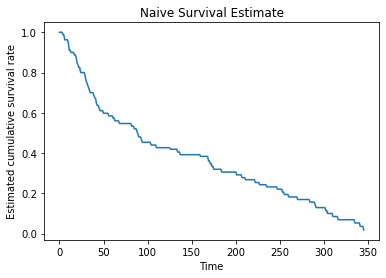

In [91]:
max_time = data.Time.max()
x = range(0, max_time) # this produces array from 0 , 1 , 2 .... max_time we can use this as index to the array of y
y = np.zeros(len(x)) # we can make this into empty array like y=[] and then append values of the fucntion like 
for t in x:
    y[t] = naive_estimator(t, data) # y.append(naive_estimator(t, data) )
    
plt.plot(x, y)
plt.title("Naive Survival Estimate")
plt.xlabel("Time")
plt.ylabel("Estimated cumulative survival rate")
plt.show()

<a name='Ex-3'></a>
### Exercise 3

Next let's compare this with the Kaplan Meier estimate. In the cell below, write a function that computes the Kaplan Meier estimate of $S(t)$ at every distinct time in the dataset. 

Recall the Kaplan-Meier estimate:

$$
S(t) = \prod_{t_i \leq t} (1 - \frac{d_i}{n_i})
$$

where $t_i$ are the events observed in the dataset and $d_i$ is the number of deaths at time $t_i$ and $n_i$ is the number of people who we know have survived up to time $t_i$.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Try sorting by Time.</li>
    <li>Use <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.unique.html">pandas.Series.unique<a> </li>
    <li>If you get a division by zero error, please double-check how you calculated `n_t`</li>
</ul>
</p>

In [238]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def HomemadeKM(df):
    """
    Return KM estimate evaluated at every distinct
    time (event or censored) recorded in the dataset.
    Event times and probabilities should begin with
    time 0 and probability 1.
    
    Example:
    
    input: 
    
         Time  Censor
    0     5       0
    1    10       1
    2    15       0
    
    correct output: 
    
    event_times: [0, 5, 10, 15]
    S: [1.0, 1.0, 0.5, 0.5]
    
    Args:
        df (dataframe): dataframe which has columns for Time
                          and Event, defined as usual.
                          
    Returns:
        event_times (list of ints): array of unique event times
                                      (begins with 0).
        S (list of floats): array of survival probabilites, so that
                            S[i] = P(T > event_times[i]). This 
                            begins with 1.0 (since no one dies at time
                            0).
    """
    # individuals are considered to have survival probability 1
    # at time 0
    event_times = [0]
    p = 1.0
    S = [p]

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get collection of unique observed event times
    observed_event_times =df.Time.values
  
    # sort event times
    observed_event_times = np.sort(observed_event_times)
    
    # iterate through event times
    for t in observed_event_times:

        # compute n_t, number of people who survive to time t /// this is super dump explanation,, you sum over all the people who lived more than t time, survived after time t !!!!!!!
        n_t =   sum( (df.Time>=t ) )

        # compute d_t, number of people who die at time t
        d_t =  sum(df[ df.Time==t].Event==1 ) #sum( (df.Time==t) & (df.Event==1) )
        # update p
        p *= 1- (d_t/n_t)

        # update S and event_times (ADD code below)
        # hint: use append
        S.append(p)
        event_times.append(t)
    
    ### END CODE HERE ###
  
    return event_times, S

In [239]:
print("TEST CASES:\n")


print("Test Case 1\n")

print("Test DataFrame:")
sample_df = pd.DataFrame(columns = ["Time", "Event"])
sample_df.Time = [5, 10, 15]
sample_df.Event = [0, 1, 0]
print(sample_df.head())
print("\nOutput:")
x, y = HomemadeKM(sample_df)
print("Event times: {}, Survival Probabilities: {}".format(x, y))
print("\nExpected:")
print("Event times: [0, 5, 10, 15], Survival Probabilities: [1.0, 1.0, 0.5, 0.5]")

print("\nTest Case 2\n")

print("Test DataFrame:")

sample_df = pd.DataFrame(columns = ["Time", "Event"])
sample_df.loc[:, "Time"] = [2, 15, 12, 10, 20]
sample_df.loc[:, "Event"] = [0, 0, 1, 1, 1]
print(sample_df.head())
print("\nOutput:")
x, y = HomemadeKM(sample_df)
print("Event times: {}, Survival Probabilities: {}".format(x, y))
print("\nExpected:")
print("Event times: [0, 2, 10, 12, 15, 20], Survival Probabilities: [1.0, 1.0, 0.75, 0.5, 0.5, 0.0]")

TEST CASES:

Test Case 1

Test DataFrame:
   Time  Event
0     5      0
1    10      1
2    15      0

Output:
Event times: [0, 5, 10, 15], Survival Probabilities: [1.0, 1.0, 0.5, 0.5]

Expected:
Event times: [0, 5, 10, 15], Survival Probabilities: [1.0, 1.0, 0.5, 0.5]

Test Case 2

Test DataFrame:
   Time  Event
0     2      0
1    15      0
2    12      1
3    10      1
4    20      1

Output:
Event times: [0, 2, 10, 12, 15, 20], Survival Probabilities: [1.0, 1.0, 0.75, 0.5, 0.5, 0.0]

Expected:
Event times: [0, 2, 10, 12, 15, 20], Survival Probabilities: [1.0, 1.0, 0.75, 0.5, 0.5, 0.0]


Now let's plot the two against each other on the data to see the difference.

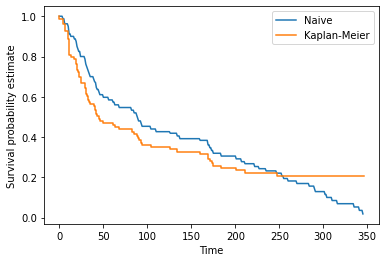

In [245]:
max_time = data.Time.max()
x = range(0, max_time)

y = np.zeros(len(x))

for t in x:
    y[t] = naive_estimator(t, data)
    
plt.plot(x, y, label="Naive")

x, y = HomemadeKM(data)
plt.step(x, y, label="Kaplan-Meier")
plt.xlabel("Time")
plt.ylabel("Survival probability estimate")
plt.legend()
plt.show()

### Question

What differences do you observe between the naive estimator and Kaplan-Meier estimator? Do any of our earlier explorations of the dataset help to explain these differences?

<a name='5'></a>
## 5. Subgroup Analysis

We see that along with Time and Censor, we have a column called `Stage_group`. 
- A value of 1 in this column denotes a patient with stage III cancer
- A value of 2 denotes stage IV. 

We want to compare the survival functions of these two groups.

This time we'll use the `KaplanMeierFitter` class from `lifelines`. Run the next cell to fit and plot the Kaplan Meier curves for each group. 

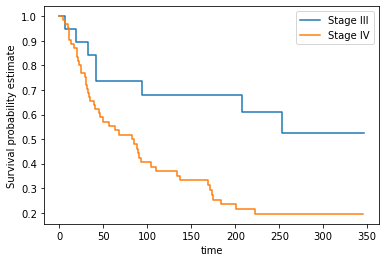

In [246]:
S1 = data[data.Stage_group == 1]
km1 = KM()
km1.fit(S1.loc[:, 'Time'], event_observed = S1.loc[:, 'Event'], label = 'Stage III')

S2 = data[data.Stage_group == 2]
km2 = KM()
km2.fit(S2.loc[:, "Time"], event_observed = S2.loc[:, 'Event'], label = 'Stage IV')

ax = km1.plot(ci_show=False)
km2.plot(ax = ax, ci_show=False)
plt.xlabel('time')
plt.ylabel('Survival probability estimate')
plt.savefig('two_km_curves', dpi=300)

Let's compare the survival functions at 90, 180, 270, and 360 days

In [247]:
survivals = pd.DataFrame([90, 180, 270, 360], columns = ['time'])
survivals.loc[:, 'Group 1'] = km1.survival_function_at_times(survivals['time']).values
survivals.loc[:, 'Group 2'] = km2.survival_function_at_times(survivals['time']).values

In [248]:
survivals

,time,Group 1,Group 2
0,90,0.736842,0.424529
1,180,0.680162,0.254066
2,270,0.524696,0.195436
3,360,0.524696,0.195436


This makes clear the difference in survival between the Stage III and IV cancer groups in the dataset. 

<a name='5-1'></a>
## 5.1 Bonus: Log-Rank Test

To say whether there is a statistical difference between the survival curves we can run the log-rank test. This test tells us the probability that we could observe this data if the two curves were the same. The derivation of the log-rank test is somewhat complicated, but luckily `lifelines` has a simple function to compute it. 

Run the next cell to compute a p-value using `lifelines.statistics.logrank_test`.

In [249]:
def logrank_p_value(group_1_data, group_2_data):
    result = logrank_test(group_1_data.Time, group_2_data.Time,
                          group_1_data.Event, group_2_data.Event)
    return result.p_value

logrank_p_value(S1, S2)

0.009588929834755544

If everything is correct, you should see a p value of less than `0.05`, which indicates that the difference in the curves is indeed statistically significant.

# Congratulations!

You've completed the third assignment of Course 2. You've learned about the Kaplan Meier estimator, a fundamental non-parametric estimator in survival analysis. Next week we'll learn how to take into account patient covariates in our survival estimates!